# Imports

In [3]:
!pip install transformers datasets evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.

In [4]:
pip install wandb

In [5]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ce6cf249ec298c105fc0ef9a710377189907fcfbe58100267cf3b8024c5b2547
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [6]:
import pandas as pd
import ast
from datasets import load_dataset

In [7]:
#subimos archivos
from google.colab import drive
drive.mount('/content/drive')

train_path = "/content/drive/MyDrive/ICAI/ProyectoFinal Deep+NLP/SA+NER/train/conll2003_train_SA.csv"
valid_path = "/content/drive/MyDrive/ICAI/ProyectoFinal Deep+NLP/SA+NER/train/conll2003_validation_SA.csv"
test_path = "/content/drive/MyDrive/ICAI/ProyectoFinal Deep+NLP/SA+NER/test/conll2003_test_SA.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv(train_path)
df_valid = pd.read_csv(valid_path)
df_test = pd.read_csv(test_path)
datasets = [df_train, df_valid, df_test]

# Preprocesado para limpiar datasets y generar inputs y outputs, por ahora ignoramos el texto de entrada (podríamso resumirlo e introducirlo resumido además)

In [ ]:
label_map = {
    0: "O",
    1: "B-PER", 2: "I-PER",
    3: "B-ORG", 4: "I-ORG",
    5: "B-LOC", 6: "I-LOC",
    7: "B-MISC", 8: "I-MISC"
}

In [ ]:
def sentimiento_label(sent):
    return "positive" if sent == 1 else "negative"

In [ ]:
#necesitamos extraer la entidad completa a partir del NER
def extraer_entidades(tokens, ner_tags):
    entidades = []
    entidad_actual = ""
    etiqueta_actual = ""

    for token, tag in zip(tokens, ner_tags):
        etiqueta = label_map.get(tag, "O")

        if etiqueta.startswith("B-"):
            if entidad_actual:
                entidades.append((entidad_actual.strip(), etiqueta_actual))
            entidad_actual = token
            etiqueta_actual = etiqueta[2:]
        elif etiqueta.startswith("I-") and etiqueta_actual == etiqueta[2:]:
            entidad_actual += " " + token
        else:
            if entidad_actual:
                entidades.append((entidad_actual.strip(), etiqueta_actual))
            entidad_actual = ""
            etiqueta_actual = ""

    if entidad_actual:
        entidades.append((entidad_actual.strip(), etiqueta_actual))

    return entidades

In [ ]:
def construir_input(row):
    entidades = "; ".join([f"{e[0]} ({e[1]})" for e in row["entities"]])
    sentimiento = sentimiento_label(row["sentiment"])
    return f"Entidades: {entidades}. Sentimiento: {sentimiento}. Texto: {row['sentence']}"

In [ ]:
def parse_numeric_list(raw):
    if isinstance(raw, list):
        return raw
    if isinstance(raw, str):
        # Elimina corchetes y convierte a lista de enteros
        cleaned = raw.strip("[]")           # quita los corchetes
        values = cleaned.split()            # separa por espacios
        try:
            return [int(x) for x in values]
        except ValueError:
            return []
    return []

for df in datasets:
    df["ner_tags"] = df["ner_tags"].apply(parse_numeric_list)

In [ ]:
import re
def parse_token_list(raw):
    if isinstance(raw, list):
        return raw
    if isinstance(raw, str):
        return re.findall(r"'(.*?)'", raw)
    return []

for df in datasets:
    df["tokens"] = df["tokens"].apply(parse_token_list)

In [ ]:
# modificamos los datasets
for df in datasets:
  df["entities"] = df.apply(lambda row: extraer_entidades(row["tokens"], row["ner_tags"]), axis=1)
  df["input_text"] = df.apply(construir_input, axis=1)

In [ ]:
import re

def clean_entities(entities):
    """
    Remove empty strings, non-word entities, or suspicious tokens from the entity list.
    """
    cleaned = []
    for ent, tag in entities:
        if not ent or not isinstance(ent, str):
            continue
        ent_clean = ent.strip()
        if not ent_clean:
            continue
        # Filtrar cosas que no parecen nombres reales de entidades
        if len(ent_clean) < 2 or re.fullmatch(r'[\W_]+', ent_clean):
            continue
        if ent_clean.lower() in ['in', 's"', 'the', 'and', 'a', 'of']:
            continue
        cleaned.append((ent_clean, tag))
    return cleaned


In [ ]:
import random
from collections import defaultdict

# Define sentiment labels
def sentimiento_label(sent):
    return "positive" if sent == 1 else "negative"

# Define confidence level
def classify_confidence(score):
    if score >= 0.95:
        return "clearly"
    elif score >= 0.7:
        return "moderately"
    else:
        return "slightly"

# Group entities by tag
def group_entities(entity_list):
    groups = defaultdict(list)
    for entity, tag in entity_list:
        groups[tag].append(entity)
    return groups

# Main alert generation function
def generate_alert(row):
    sentiment = sentimiento_label(row["sentiment"])
    intensity = classify_confidence(row["sentiment_score"])
    text = row["sentence"]

    # Convert from string if needed
    entities = clean_entities(row["entities"])
    #print(entities)

    if isinstance(entities, str):
        try:
            entities = eval(entities)
        except:
            entities = []

    grouped = group_entities(entities)

    # Variability in phrasing
    person_phrases = [
        "Mentions",
        "Includes",
        "Features",
        "Highlights",
        "Refers to"
    ]

    org_phrases = [
        "Involving organizations such as",
        "With the participation of",
        "Featuring institutions:"
    ]
    loc_phrases = [
        "Across regions like",
        "Referencing places including"
    ]
    misc_phrases = [
        "Including concepts like",
        "With references to",
        "Touching on elements like"
    ]

    summary_parts = f"Alert with a {intensity} {sentiment} tone."

    # Add entities by category
    if grouped:
        if grouped.get("PER"):
            people_str = ", ".join(grouped["PER"])
            summary_parts += f"{random.choice(person_phrases)} {people_str.lower()}."

        if grouped.get("ORG"):
            orgs_str = ", ".join(grouped["ORG"])
            summary_parts += f"{random.choice(org_phrases)} {orgs_str}."

        if grouped.get("LOC"):
            locs_str = ", ".join(grouped["LOC"])
            summary_parts += f"{random.choice(loc_phrases)} {locs_str}."

        if grouped.get("MISC"):
            misc_str = ", ".join(grouped["MISC"])
            summary_parts += f"{random.choice(misc_phrases)} {misc_str.lower()}."
    else:
        summary_parts += "No specific entities mentioned."

    #print(summary_parts)
    return summary_parts


In [ ]:
for df in datasets:
  df["target_text"] = df.apply(generate_alert, axis=1)


In [ ]:
#comprobamos
datasets[0].columns



Index(['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'sentence',
       'sentiment', 'sentiment_score', 'entities', 'input_text',
       'target_text'],
      dtype='object')

In [ ]:
datasets[0]["input_text"][0]

'Entidades: EU (ORG); German (MISC); British (MISC). Sentimiento: positive. Texto: EU rejects German call to boycott British lamb .'

In [ ]:
datasets[0]["target_text"][10]

'Alert with a clearly negative tone.Refers to loyola de palacio, fischler.Featuring institutions: EU.Including concepts like spanish.'

In [ ]:
#nos quedamos solo con input text y target_text
output_df = [df[["input_text","target_text"]].copy() for df in datasets]

In [ ]:
#maximo de inputs y outputs
max(len(text) for text in datasets[0]["input_text"])

683

In [ ]:
max(len(text) for text in datasets[0]["target_text"])

322

In [ ]:
names = ["train", "valid","test"]

for df, name in zip(output_df, names):
    df.to_csv(f"{name}_AG.csv", index=False)

# Entrenamiento modelo T5

In [8]:
#importar los datasets que hemos creado anteriormente
from datasets import load_dataset, Dataset
train_path = "/content/drive/MyDrive/ICAI/ProyectoFinal Deep+NLP/AG/train_AG.csv"
valid_path = "/content/drive/MyDrive/ICAI/ProyectoFinal Deep+NLP/AG/valid_AG.csv"
test_path = "/content/drive/MyDrive/ICAI/ProyectoFinal Deep+NLP/AG/test_AG.csv"

df_AGtrain = pd.read_csv(train_path)
df_AGvalid = pd.read_csv(valid_path)
df_AGtest = pd.read_csv(test_path)
#reducimos para pruebas
df_AGtrain_small = df_AGtrain.sample(frac=0.1, random_state=42)
df_AGvalid_small = df_AGvalid.sample(frac=0.1, random_state=42)
df_AGtest_small = df_AGtest.sample(frac=0.1, random_state=42)

train_dataset = Dataset.from_pandas(df_AGtrain_small)
valid_dataset = Dataset.from_pandas(df_AGvalid_small)
test_dataset = Dataset.from_pandas(df_AGtest_small)

In [9]:
#tokenizamos para el modelo preentrenado
from transformers import AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration

model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name,from_tf=False)

#a ojo de nuestros datos
max_input_len = 70
max_target_len = 70

def preprocess_function(examples):
    inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=max_input_len)
    targets = tokenizer(examples["target_text"], padding="max_length", truncation=True, max_length=max_target_len)

    inputs["labels"] = targets["input_ids"] #le indicamaos exactamente cúal debe ser la salida
    return inputs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

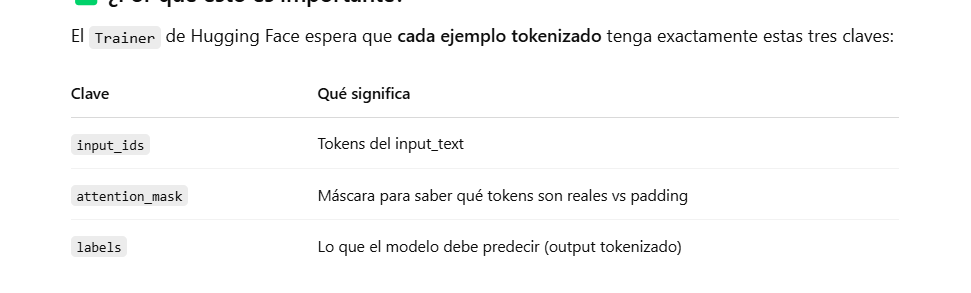

In [10]:
train_tokenized_dataset = train_dataset.map(preprocess_function)
print(train_tokenized_dataset[0])#todo números

Map:   0%|          | 0/1404 [00:00<?, ? examples/s]

{'input_text': 'Entidades: . Sentimiento: positive. Texto: Attendance : 1,800', 'target_text': 'Alert with a clearly positive tone.No specific entities mentioned.', '__index_level_0__': 13944, 'input_ids': [4443, 15644, 15, 7, 10, 3, 5, 4892, 2998, 4741, 32, 10, 1465, 5, 5027, 32, 10, 22497, 663, 3, 10, 1914, 6192, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [23951, 28, 3, 9, 3133, 1465, 5739, 5, 4168, 806, 12311, 2799, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [11]:
valid_tokenized_dataset = valid_dataset.map(preprocess_function)
test_tokenized_dataset = test_dataset.map(preprocess_function)

Map:   0%|          | 0/325 [00:00<?, ? examples/s]

Map:   0%|          | 0/345 [00:00<?, ? examples/s]

In [12]:
#data collator
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [13]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
# argumentos a tocar con el modelo
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-alerts-model",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=10,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    report_to="none",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
#from datasets import load_metric

import evaluate
import numpy as np

# Cargar el métrico ROUGE una vez
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Decodificar outputs
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Reemplazar -100 por el token de padding para poder decodificar etiquetas
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Calcular ROUGE
    result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    # Extraer solo ROUGE-1 y ROUGE-L (F1 score)
    final_scores = {
    "rouge1": round(result["rouge1"] * 100, 2),
    "rougeL": round(result["rougeL"] * 100, 2)
  }

    return final_scores

In [17]:


#import os
#os.environ["WANDB_DISABLED"] = "true" #para que no nos pida loggearnos en una web extraña
#entrenamos
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=valid_tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-17-23ee8473fbeb>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Rouge1,Rougel
1,0.116200,0.130521,76.190000,75.260000
2,0.118700,0.110090,75.130000,74.580000
3,0.097200,0.097662,76.830000,76.230000
4,0.086600,0.090142,77.420000,77.070000
5,0.070100,0.087722,76.390000,76.070000
6,0.071900,0.083609,75.650000,75.450000
7,0.071100,0.083395,76.980000,76.810000
8,0.062700,0.083561,77.470000,77.150000
9,0.058900,0.081837,77.130000,76.880000
10,0.062100,0.082014,77.280000,77.050000


TrainOutput(global_step=880, training_loss=0.08443753726103088, metrics={'train_runtime': 319.8948, 'train_samples_per_second': 43.889, 'train_steps_per_second': 2.751, 'total_flos': 259792817356800.0, 'train_loss': 0.08443753726103088, 'epoch': 10.0})

In [18]:
#evaluamos el modelo
trainer.evaluate(train_tokenized_dataset)

{'eval_loss': 0.040559981018304825,
 'eval_rouge1': 79.61,
 'eval_rougeL': 79.48,
 'eval_runtime': 36.5537,
 'eval_samples_per_second': 38.409,
 'eval_steps_per_second': 2.407,
 'epoch': 10.0}

In [19]:
trainer.evaluate(valid_tokenized_dataset)

{'eval_loss': 0.08201374113559723,
 'eval_rouge1': 77.28,
 'eval_rougeL': 77.05,
 'eval_runtime': 8.5793,
 'eval_samples_per_second': 37.882,
 'eval_steps_per_second': 2.448,
 'epoch': 10.0}

In [20]:
trainer.evaluate(test_tokenized_dataset)

{'eval_loss': 0.06812108308076859,
 'eval_rouge1': 79.62,
 'eval_rougeL': 79.52,
 'eval_runtime': 9.6279,
 'eval_samples_per_second': 35.833,
 'eval_steps_per_second': 2.285,
 'epoch': 10.0}

In [24]:
import torch
predictions = []
references = []

for example in test_tokenized_dataset:
    input_ids =  torch.tensor([example["input_ids"]]).to(model.device)

    # Generar
    output_ids = model.generate(input_ids=input_ids, max_length=70, num_beams=4, early_stopping=True)
    pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    predictions.append(pred)
    references.append(example["target_text"])


NameError: name 'df_test' is not defined

In [25]:

df_out = pd.DataFrame({
    "input_text": df_AGtest_small["input_text"],
    "prediction": predictions,
    "reference": references
})

df_out.to_csv("predictions_test.csv", index=False)